In [1]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas as pd 
import arch
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
import itertools
from scipy.stats import shapiro, jarque_bera
from scipy.stats import norm
from statsmodels.stats.diagnostic import het_arch
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

C:\Users\six_h\anaconda3\Lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\six_h\anaconda3\Lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
C:\Users\six_h\anaconda3\Lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


[*********************100%%**********************]  1 of 1 completed


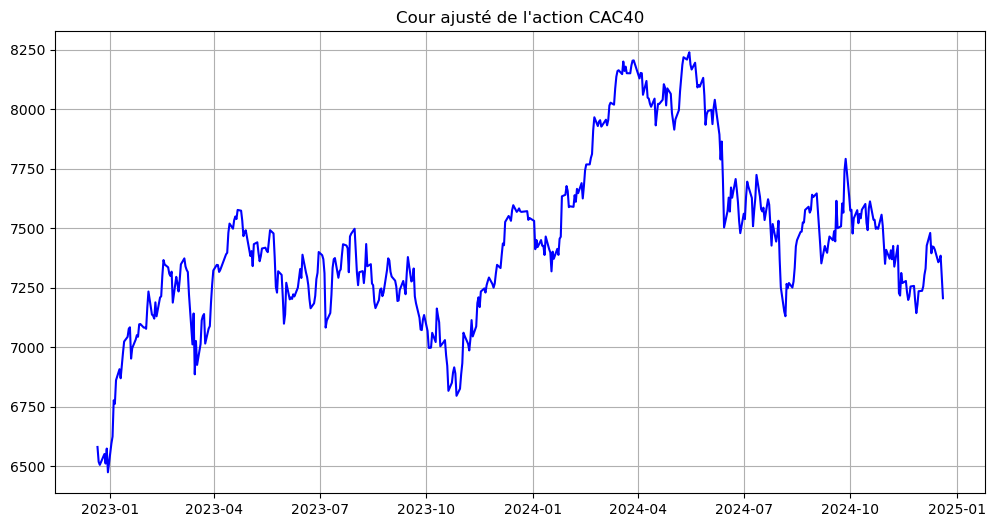

In [2]:
ticker = '^FCHI'
action = 'CAC40'

aujourdhui = datetime.today()
date_debut = aujourdhui - timedelta(days=365*2)

aujourdhui_formatted = aujourdhui.strftime("%Y-%m-%d")
date_debut_formatted = date_debut.strftime("%Y-%m-%d")

cac40 = yf.download(ticker, start=date_debut_formatted, end=aujourdhui)
cac40 = cac40['Adj Close']

plt.figure(figsize=(12, 6))
plt.plot(cac40.index, cac40, color='blue')
plt.title(f'Cour ajusté de l\'action {action}')
plt.grid(True)
plt.show()

**Plot de l'autocorrélation de la série en ACF et PACF**

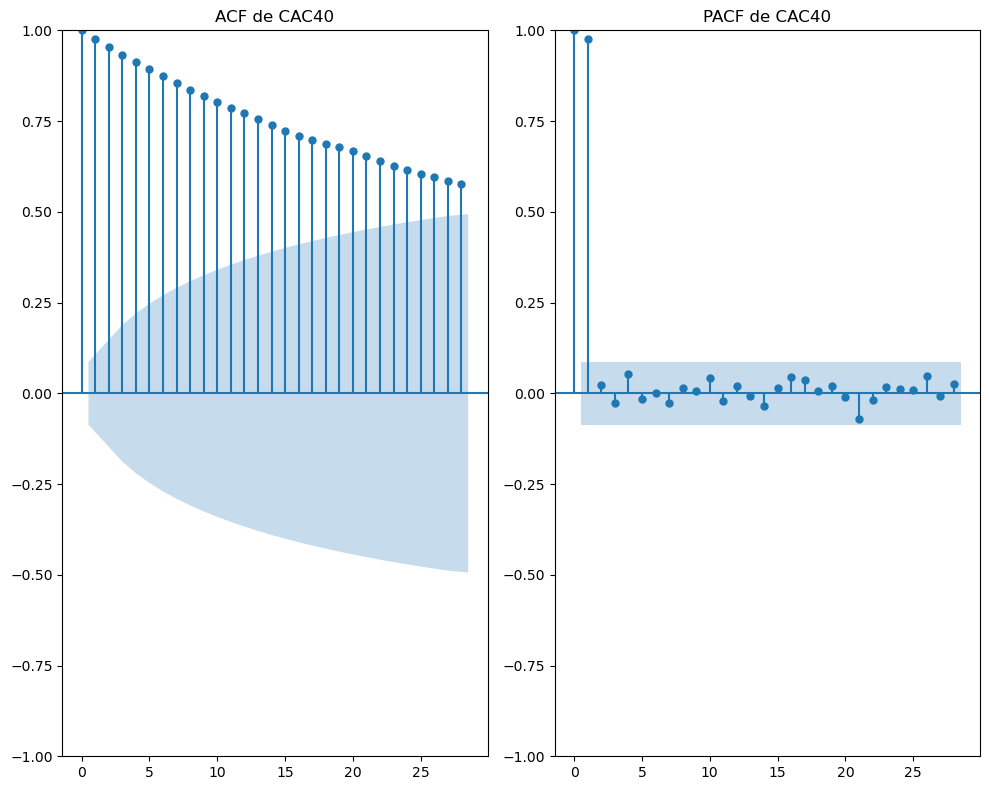

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,8))
plot_acf(cac40, ax=ax1)
ax1.set_title(f"ACF de {action}")

plot_pacf(cac40, ax=ax2)
ax2.set_title(f"PACF de {action}")
plt.tight_layout()
plt.show()

**On voit que la série est autocorrélée**

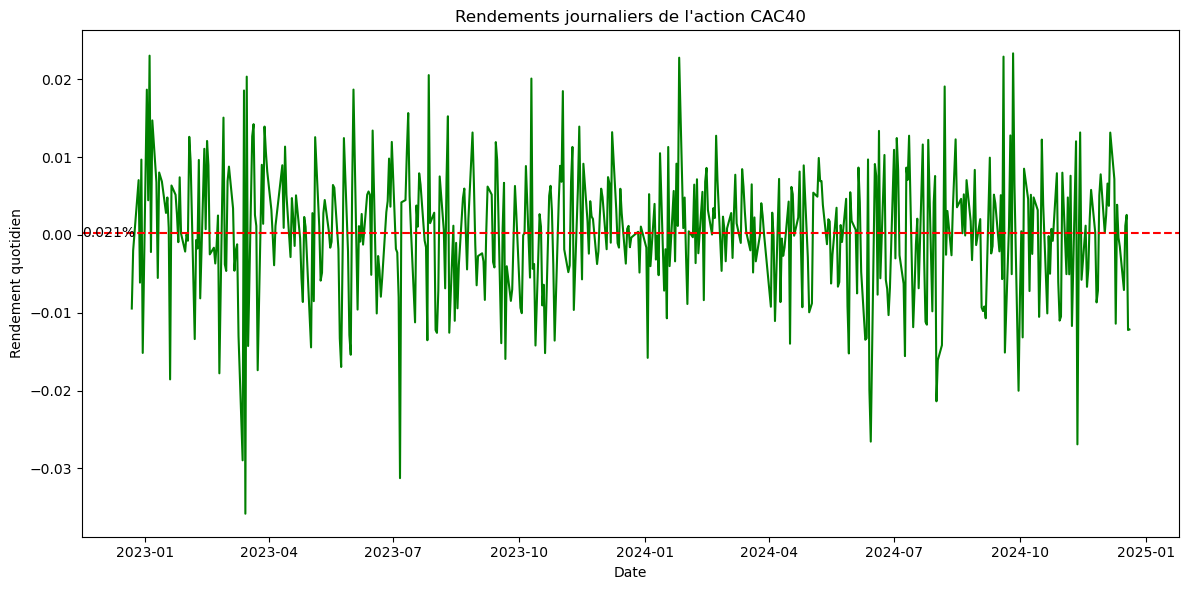

In [4]:
returns = cac40.pct_change().dropna()
return_moyen = returns.mean()

plt.figure(figsize=(12,6))
plt.plot(returns.index, returns, color="green")
plt.axhline(y=return_moyen, color='red', linestyle = '--')
plt.text(0, return_moyen, f'{return_moyen*100:.3f}%', verticalalignment='center', 
         horizontalalignment='left', transform=plt.gca().get_yaxis_transform())

plt.title(f'Rendements journaliers de l\'action {action}')
plt.xlabel('Date')
plt.ylabel('Rendement quotidien')
plt.tight_layout()
plt.show()

**le ACF et PACF de la série des rendements**

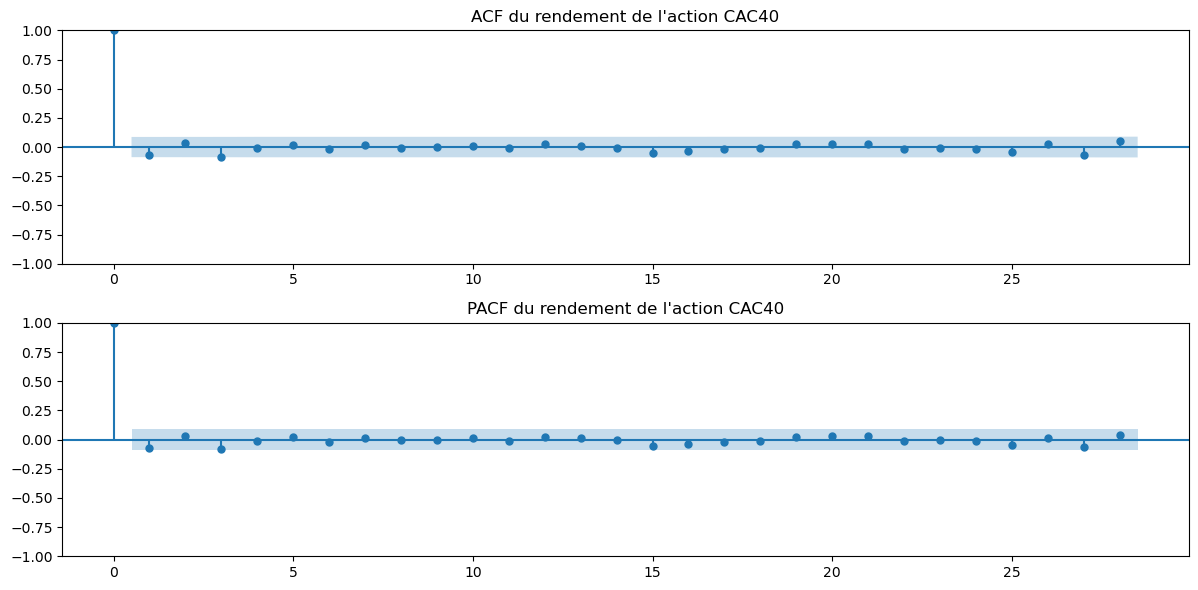

In [5]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,6))

plot_acf(returns, ax=ax1)
ax1.set_title(f'ACF du rendement de l\'action {action}')

plot_pacf(returns, ax=ax2)
ax2.set_title(f'PACF du rendement de l\'action {action}')
              
plt.tight_layout()
plt.show()

# Génius !! on voit que la série est stationnaire, ce qui signifie que maintenant on va pouvoir
# commencer à travailler

**On vérifie quand même statistiquement avec un petit test de Dickey Fuller que la série est réellement stationnaire**

In [6]:
dickey_fuller = adfuller(returns)

dickey_fuller_statistique = dickey_fuller[0]
dickey_fuller_p_value = dickey_fuller[1]
dickey_fuller_1_pour_cent = dickey_fuller[4]['1%']
dickey_fuller_5_pour_cent = dickey_fuller[4]['5%']
dickey_fuller_10_pour_cent = dickey_fuller[4]['10%']


print(f"""La statistique DF : {dickey_fuller_statistique} 
La p-value 5% du test : {dickey_fuller_p_value} 
La t-stat 1% : {dickey_fuller_1_pour_cent} 
La t-stat 5% : {dickey_fuller_5_pour_cent} 
La t-stat 10% : {dickey_fuller_10_pour_cent} \n""")


if (float(dickey_fuller_p_value) < float(5/100)):
    print("La série est stationnaire")
else: 
    print("La série n'est pas stationnaire")

La statistique DF : -24.173641067241526 
La p-value 5% du test : 0.0 
La t-stat 1% : -3.4432119442564324 
La t-stat 5% : -2.8672126791646955 
La t-stat 10% : -2.569791324979607 

La série est stationnaire


In [7]:
df_return_return = pd.concat([returns, returns.shift(1)], axis=1).dropna()
df_return_return = df_return_return.rename(columns={'Adj Close':'rendement_n', 'Adj Close':'rendement_n_1'})
colonnes = list(df_return_return.columns)
colonnes[0] = "rendement n"
colonnes[1] = "rendement n-1"
df_return_return.columns = colonnes

df_return_return

,rendement n,rendement n-1
Date,,
2022-12-23,-0.002005,-0.009463
2022-12-27,0.007035,-0.002005
2022-12-28,-0.006132,0.007035
2022-12-29,0.009674,-0.006132
2022-12-30,-0.015169,0.009674
...,...,...
2024-12-16,-0.007084,-0.001532
2024-12-17,0.001172,-0.007084
2024-12-18,0.002569,0.001172


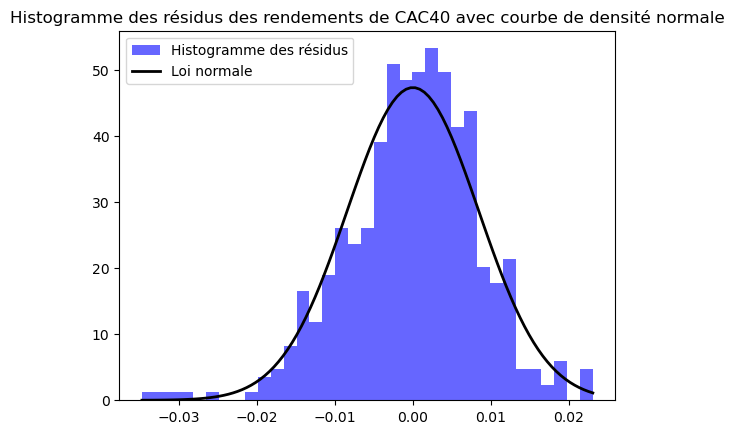

In [8]:
# Création du modèle et calcul des résidus
Y = df_return_return['rendement n']
X = df_return_return['rendement n-1']
X = sm.add_constant(X)
model = sm.OLS(Y, X)
results = model.fit()
residus = results.resid

# Tracer l'histogramme des résidus
plt.hist(residus, bins=35, density=True, alpha=0.6, color='b', label='Histogramme des résidus')

# Calcul de la densité normale
mu, std = np.mean(residus), np.std(residus)  # Moyenne et écart-type des résidus
min_residus = np.min(residus) 
max_residus = np.max(residus) 

x = np.linspace(min_residus, max_residus, 100)  # Générer des points pour tracer la courbe
p = norm.pdf(x, mu, std)  # Calculer la densité normale

# Ajouter la courbe de la loi normale
plt.plot(x, p, 'k', linewidth=2, label='Loi normale')
plt.title(f"Histogramme des résidus des rendements de {action} avec courbe de densité normale")
plt.legend()
plt.show()

Après avoir réalisé la régression des rendements "n" sur les rendements "n-1" vérifions si les résidus des rendements sont corrélés dans le temps avant de lancer un modèle GARCH

In [9]:
df_residus_rendements = pd.concat([residus, residus.shift(1)], axis=1).dropna()
nom_colonnes_df_residus = list(df_residus_rendements.columns)
nom_colonnes_df_residus[0] = "residus rendements N"
nom_colonnes_df_residus[1] = "residus rendement N-1"
df_residus_rendements.columns = nom_colonnes_df_residus

y = df_residus_rendements["residus rendements N"]
x = df_residus_rendements["residus rendement N-1"]
x = sm.add_constant(x)

model = sm.OLS(y,x)
regression = model.fit()
regression.params

print(regression.t_test([1, 0]))
# Résidus des rendements non corrélés

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0          5.678e-06      0.000      0.015      0.988      -0.001       0.001


In [10]:
df_garch = pd.DataFrame(columns=['p', 'q', 'aic'])

for p in range(1,4):
    for q in range(0,4):
        
        model = arch.arch_model(returns, vol='Garch', p=p, q=q)
        model_results = model.fit(disp='off')
        aic = model_results.aic
        
        df_garch = pd.concat([df_garch, pd.DataFrame({'p': [p], 'q': [q], 'aic': [aic]})], ignore_index=True)
        
df_garch = df_garch.reset_index(drop=True)
df_garch.sort_values(by='aic')

# Le AIC le plus négatif est pour le GARCH (1,1) on va donc utiliser ce dernier pour prédire

,p,q,aic
1,1,1,-3458.611748
2,1,2,-3455.340856
5,2,1,-3453.631729
3,1,3,-3452.300890
6,2,2,-3451.809885
7,2,3,-3449.650380
9,3,1,-3448.542529
10,3,2,-3446.004570
11,3,3,-3443.687388
4,2,0,-3420.561467


Maintenant voyons si le modèle GARCH (1,1) est valide quand même.. Même si c'est le meilleur de la liste, rien ne nous confirme jusque là qu'il est vraiment valide 

### Modèle de la volatilité conditionnelle

La variance conditionnelle $\sigma^2_t$ est donnée par :

$$\sigma^2_t = \omega + \sum_{i=1}^{p} \alpha_i \varepsilon_{t-i}^2 + \sum_{j=1}^{q} \beta_j \sigma_{t-j}^2$$


### Exemple spécifique : GARCH(1, 1)

Pour un modèle GARCH(1, 1), la variance conditionnelle se présente comme :

$$\sigma^2_t = \omega + \alpha_1 \varepsilon_{t-1}^2 + \beta_1 \sigma_{t-1}^2$$

### Objectif du modèle

Le modèle GARCH vise à capturer la dynamique de la volatilité pour prédire la volatilité future de la série chronologique. Il est particulièrement utile pour modéliser la volatilité des rendements des actifs financiers.


In [11]:
model = arch.arch_model(returns, vol='Garch', p=1, q=1)
results = model.fit()
print(results.summary())

# la volatilité passée semble influencer fortement la volatilité du jour

Iteration:      1,   Func. Count:      6,   Neg. LLF: 10482889554.360004
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1082.8857278940213
Iteration:      3,   Func. Count:     28,   Neg. LLF: -876.6293661933689
Iteration:      4,   Func. Count:     37,   Neg. LLF: -40.136959141610305
Iteration:      5,   Func. Count:     47,   Neg. LLF: -1655.1321654514652
Iteration:      6,   Func. Count:     54,   Neg. LLF: -1721.5572927173355
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1733.3058741826094
            Iterations: 6
            Function evaluations: 62
            Gradient evaluations: 6
                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                1733.31
Distribution:                  No

Validation du modèle

Statistique de Shapiro-Wilk: 0.9862872362136841, p-value: 9.556482109474018e-05
Les résidus ne sont pas normalement distribués, le modèle GARCH actuel n'est pas parfait


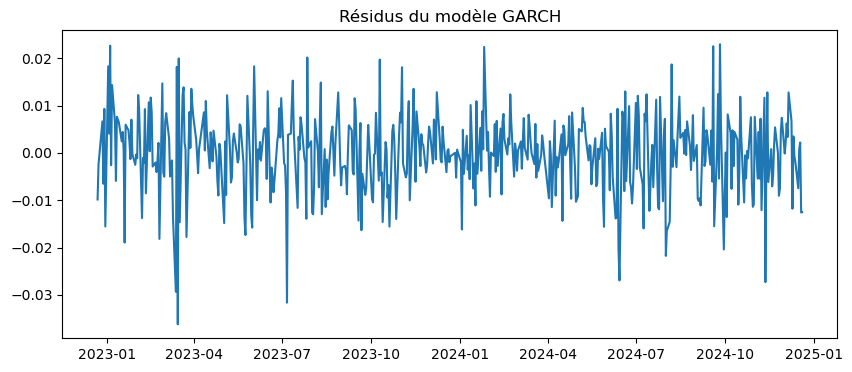

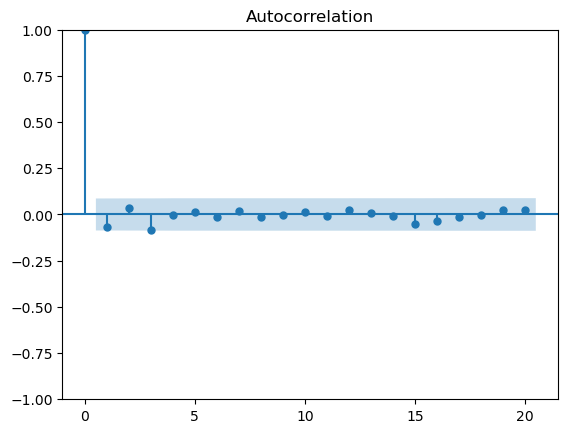

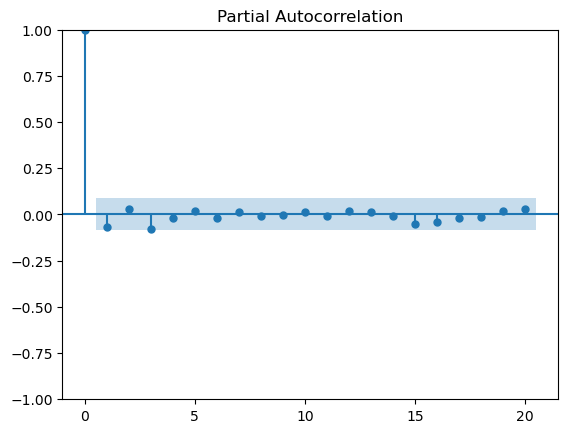

In [12]:
# Plot des résidus
plt.figure(figsize=(10,4))
plt.plot(results.resid)
plt.title("Résidus du modèle GARCH")

plot_acf(results.resid, lags=20)
plot_pacf(results.resid, lags=20)

# Test de Shapiro-Wilk pour la normalité pour les résidus du GARCH(1,1)
stat, p = shapiro(results.resid)
print(f'Statistique de Shapiro-Wilk: {stat}, p-value: {p}')
if (p>0.05):
    print("Les résidus peuvent être considérés comme normaux et le modèle GARCH actuel est efficace")
else:
    print("Les résidus ne sont pas normalement distribués, le modèle GARCH actuel n'est pas parfait")

L'heure de la prévision a sonnée

In [13]:
rolling_predictions = []
test_size = 150

for i in range(test_size):
    train = returns[:-(test_size-i)] # première ligne jusqu'à test_size
    model = arch.arch_model(train, p=1, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0])) # récupère la variance à la position 0

rolling_predictions = pd.Series(rolling_predictions, index=returns.index[-test_size:])

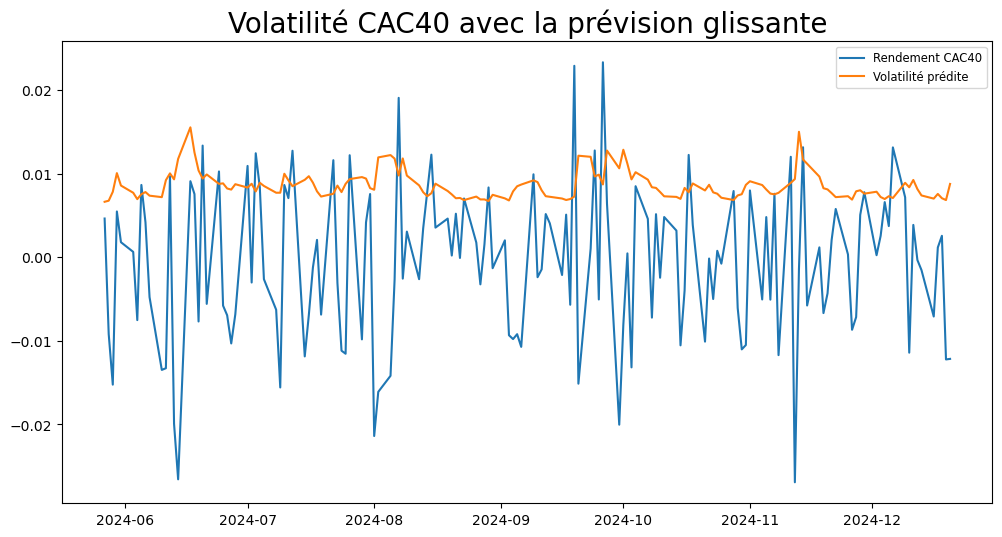

In [14]:
plt.figure(figsize=(12,6))
plt.plot(returns[-test_size:])
plt.plot(rolling_predictions)
plt.title('Volatilité CAC40 avec la prévision glissante', fontsize=20)
plt.legend(['Rendement CAC40', 'Volatilité prédite'], fontsize='small')

## Mélanger GARCH et RSI et décider

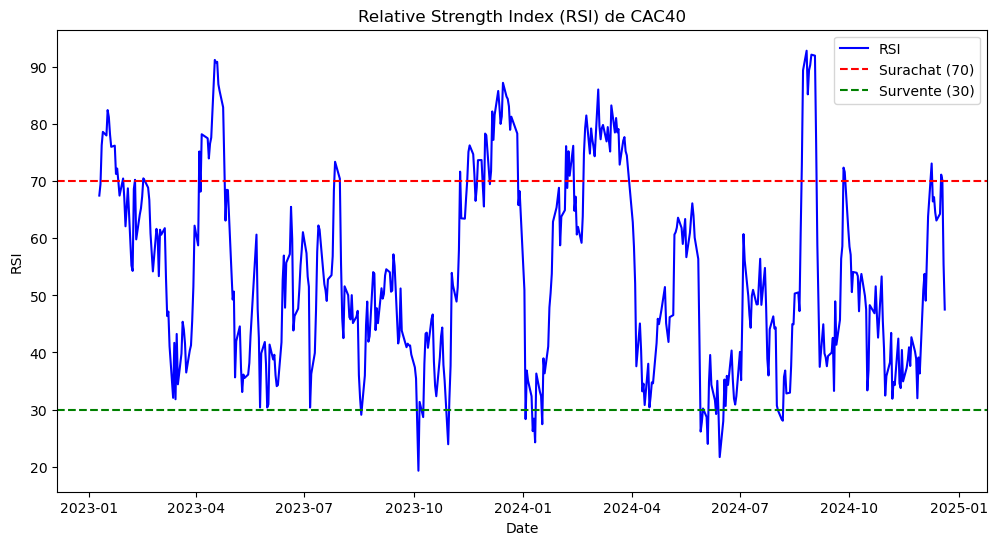

In [15]:
def relative_strength_index(data, window=14):
    
    delta = data.diff(1)
    gain = delta.where(delta>0, 0) # retourne 0 si la condition n'est pas remplie
    perte = -delta.where(delta<0, 0) # on rend la perte > 0 pour comparaison ratio positif
    
    gain_moyen = gain.rolling(window=window, min_periods=window).mean()
    perte_moyenne = perte.rolling(window=window, min_periods=window).mean()
    momentum = gain_moyen/perte_moyenne
    
    rsi = 100 - (100 / (1+momentum))
    return rsi


# On retravaille notre dataframe cac40 qui comporte les rendements et on lui ajoute une colonne
# avec le RSI

df = pd.DataFrame(returns)
colonnes_df = list(df.columns)
colonnes_df[0] = 'rendements CAC40'
df.columns = colonnes_df

df['RSI'] = relative_strength_index(cac40)


plt.figure(figsize=(12, 6))
plt.plot(df.index, df['RSI'], label='RSI', color='blue')
plt.axhline(70, linestyle='--', color='red', label='Surachat (70)')
plt.axhline(30, linestyle='--', color='green', label='Survente (30)')
plt.title(f'Relative Strength Index (RSI) de {action}')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()
plt.show()

### Enfin on plot ensemble RSI et Volatilité prédite par le GARCH pour décider si on achète, vend, ou attend

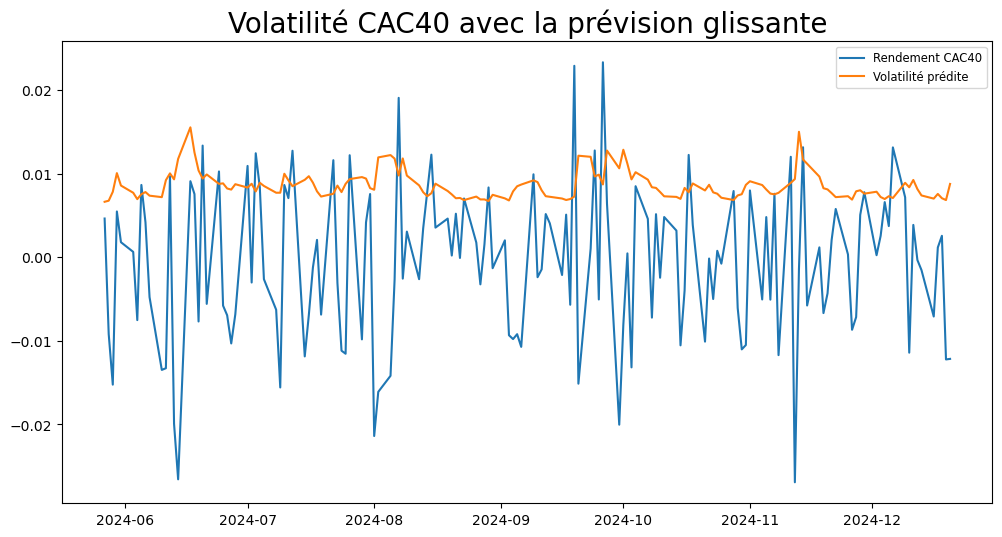

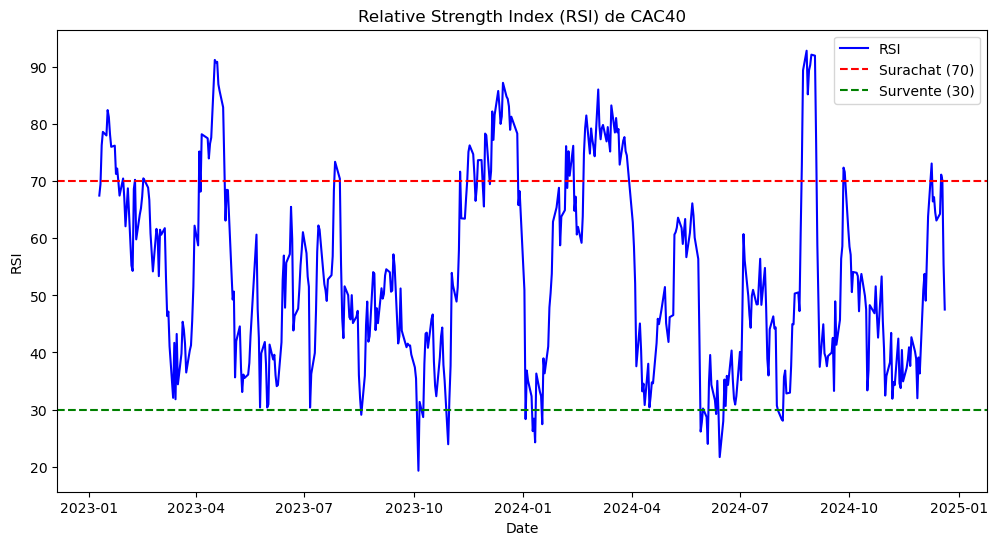

In [16]:
plt.figure(figsize=(12,6))

plt.plot(returns[-test_size:]) # les vrais à partir des test_size dernier
plt.plot(rolling_predictions) # les prédiction du horizon de la même date

plt.title(f'Volatilité {action} avec la prévision glissante', fontsize=20)
plt.legend([f'Rendement {action}', 'Volatilité prédite'], fontsize='small')

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['RSI'], label='RSI', color='blue')
plt.axhline(70, linestyle='--', color='red', label='Surachat (70)')
plt.axhline(30, linestyle='--', color='green', label='Survente (30)')
plt.title(f'Relative Strength Index (RSI) de {action}')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()
plt.show()

Anticipation (projection) de la volatilité à venir

(array([42., 42., 31., 18.,  2.,  7.,  6.,  0.,  0.,  2.]),
 array([0.00663768, 0.00752795, 0.00841822, 0.00930849, 0.01019876,
        0.01108904, 0.01197931, 0.01286958, 0.01375985, 0.01465013,
        0.0155404 ]),
 <BarContainer object of 10 artists>)

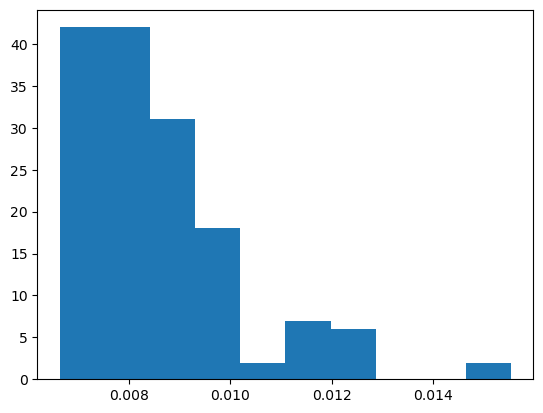

In [17]:
plt.hist(rolling_predictions)

([0, 1, 2],
 [Text(0, 0, '2024-12-21'),
  Text(1, 0, '2024-12-22'),
  Text(2, 0, '2024-12-23')])

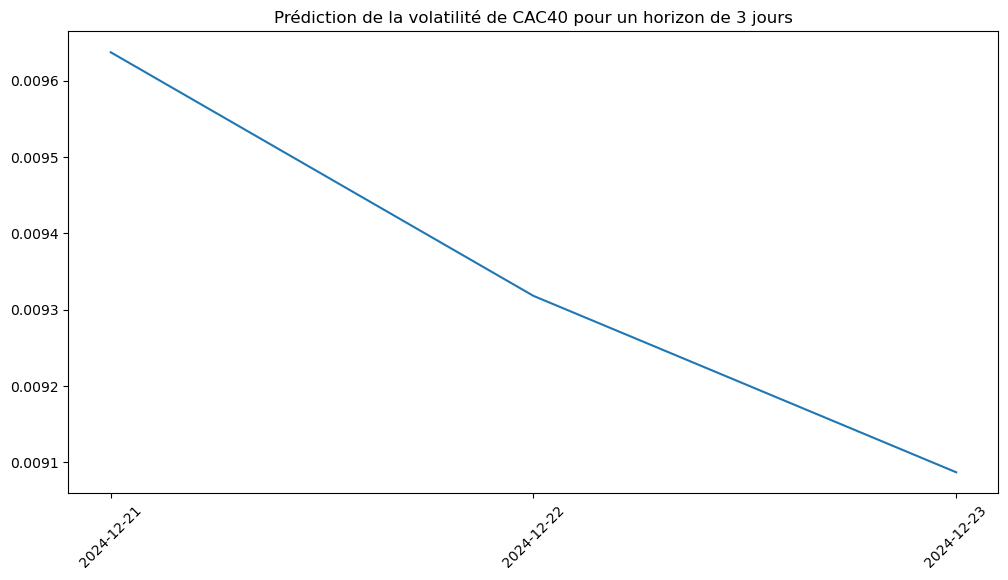

In [18]:
horizon = 3
train = returns
model = arch.arch_model(train, p=1, q=1)
model_pret = model.fit(disp='off')
prediction = model_pret.forecast(horizon=horizon)
dates = [returns.index[-1] + timedelta(days=i) for i in range(1,horizon+1)]
formatted_dates = [date.strftime('%Y-%m-%d') for date in dates]

prediction = pd.Series(np.sqrt(prediction.variance.values[-1,:]), index=dates)

plt.figure(figsize=(12,6))
plt.plot(formatted_dates, prediction)
plt.title(f'Prédiction de la volatilité de {action} pour un horizon de {horizon} jours')
plt.xticks(rotation=45)

RMSE: 6.680662583569385


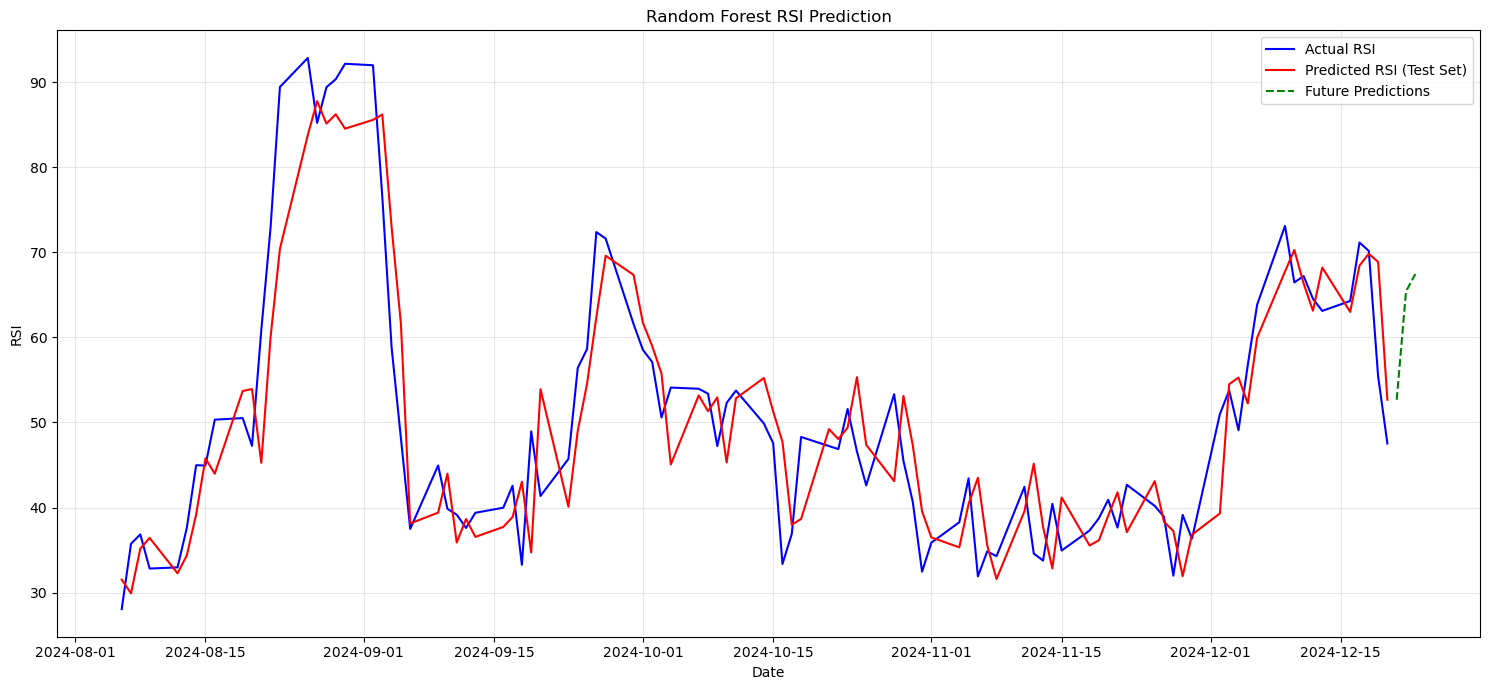

Prédictions pour les 10 prochaines périodes:
2024-12-21: 52.67
2024-12-22: 65.41
2024-12-23: 67.47


In [19]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Préparation des données
def create_features(df, n_in=1):
    df = df.copy()
    for i in range(1, n_in + 1):
        df[f'RSI_lag_{i}'] = df['RSI'].shift(i)
    df.dropna(inplace=True)
    return df

# Créer les features
n_in = 5  # Utiliser 10 jours passés pour prédire
features = create_features(df[['RSI']], n_in=n_in)

# Séparer les features et la cible
X = features.drop('RSI', axis=1)
y = features['RSI']

# Diviser en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Créer et entraîner le modèle Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Faire des prédictions
y_pred = rf.predict(X_test)

# Calculer l'erreur
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")

# Prédire les prochaines valeurs
n_future_predictions = 3  # Nombre de valeurs futures à prédire
last_data = X.iloc[-1:].values
future_pred = []
for _ in range(n_future_predictions):
    pred = rf.predict(last_data)
    future_pred.append(pred[0])
    last_data = np.roll(last_data, -1)
    last_data[0, -1] = pred[0]

# Créer un index pour les prédictions futures
future_index = pd.date_range(start=y_test.index[-1] + pd.Timedelta(days=1), periods=n_future_predictions)

# Tracer les résultats
plt.figure(figsize=(15, 7))
plt.plot(y_test.index, y_test.values, label='Actual RSI', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted RSI (Test Set)', color='red')
plt.plot(future_index, future_pred, label='Future Predictions', color='green', linestyle='--')
plt.title('Random Forest RSI Prediction')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Prédictions pour les 10 prochaines périodes:")
for date, pred in zip(future_index, future_pred):
    print(f"{date.date()}: {pred:.2f}")

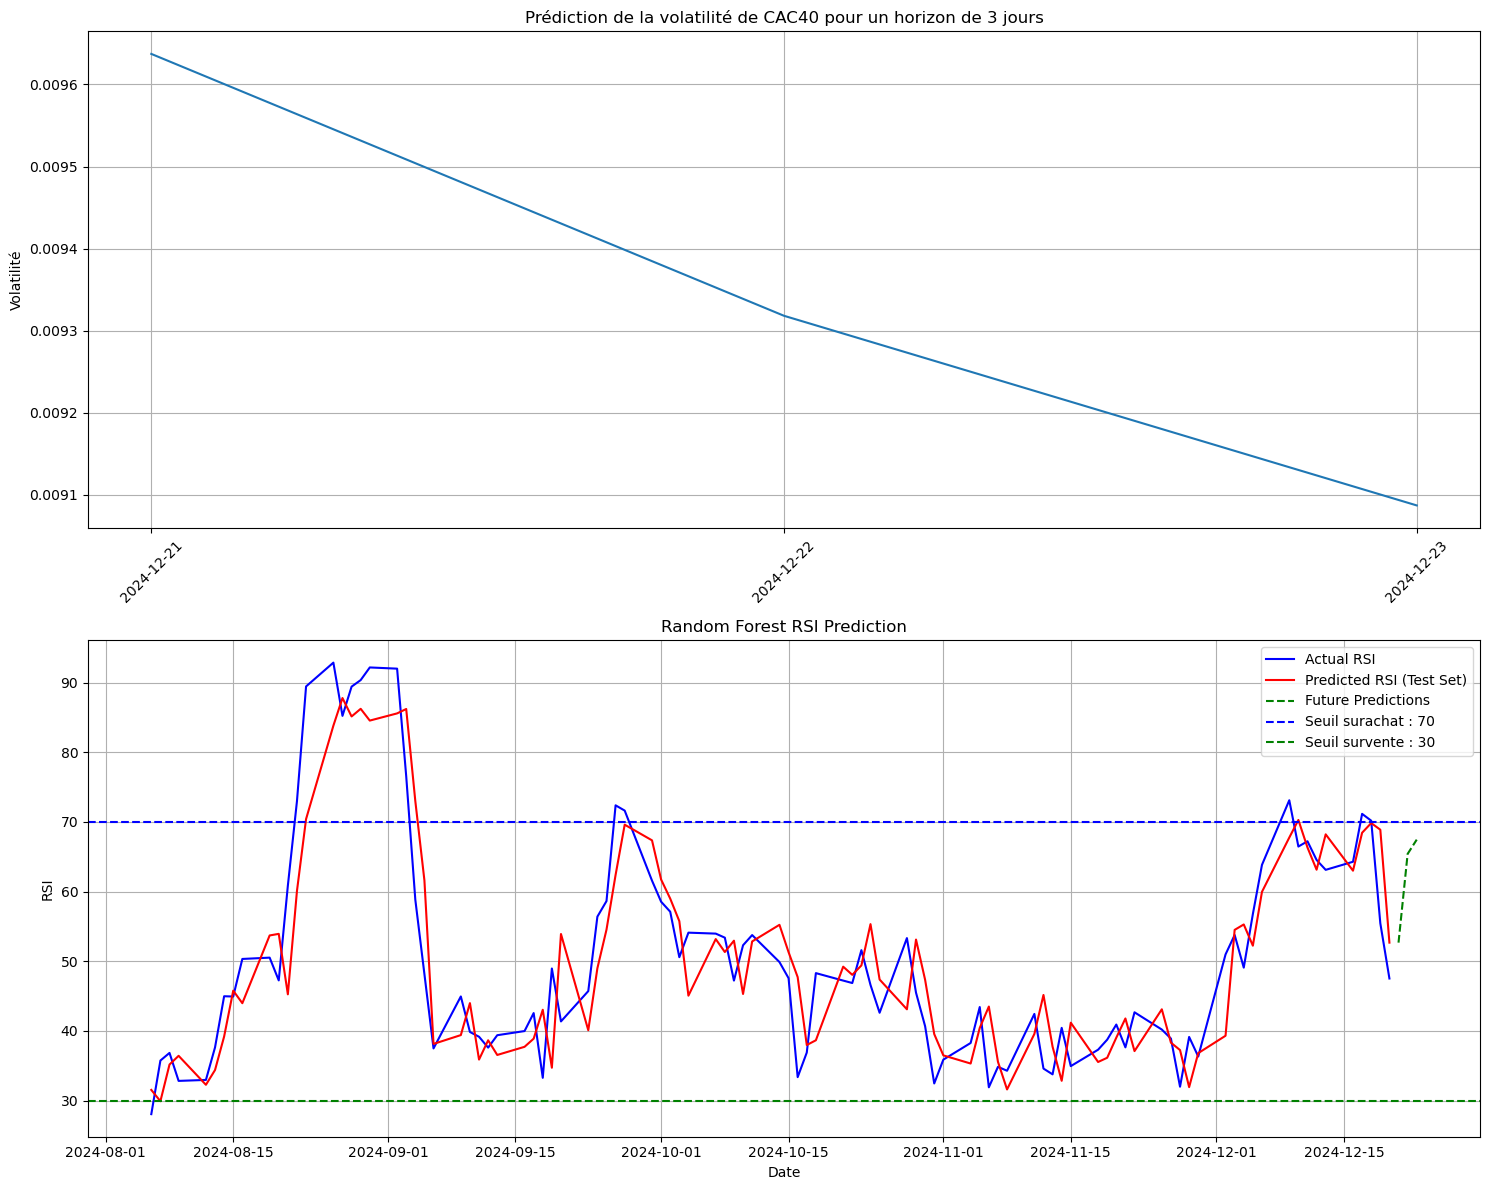

In [20]:
# Taille générale
plt.figure(figsize=(15, 12))

# Premier graphique : Prédiction de la volatilité
plt.subplot(2, 1, 1)  # 2 lignes, 1 colonne, premier graphique
plt.plot(formatted_dates, prediction)  # Assurez-vous que formatted_dates et prediction sont définis
plt.title(f'Prédiction de la volatilité de {action} pour un horizon de {horizon} jours')
plt.xticks(rotation=45)
plt.ylabel('Volatilité')
plt.grid(True)

# Deuxième graphique : Prédiction RSI
plt.subplot(2, 1, 2)  # 2 lignes, 1 colonne, deuxième graphique
plt.plot(y_test.index, y_test.values, label='Actual RSI', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted RSI (Test Set)', color='red')
plt.plot(future_index, future_pred, label='Future Predictions', color='green', linestyle='--')
plt.axhline(70, linestyle="--", color='blue', label="Seuil surachat : 70")
plt.axhline(30, linestyle="--", color='green', label="Seuil survente : 30")
plt.title('Random Forest RSI Prediction')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.show()